In [1]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

In [2]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.5.4:37907 Dashboard: /user/0000-0001-7783-5629/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import sys, glob
import numpy as np
import xarray as xr
import xscale.spectral.fft as xfft
import xscale 
import Wavenum_freq_spec_func as wfs
import time

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
from matplotlib.colors import LogNorm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [5]:
%%time
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')

gcsmapgridv=gcsfs.mapping.GCSMap('pangeo-data/NATL60-CJM165-SSV-1h-1m2deg2deg',gcs=fs,check=False,create=False)
dsv=xr.open_zarr(gcsmapgridv)


gcsmapgriduJAS=gcsfs.mapping.GCSMap('pangeo-data/zarr_NATL60-CJM165_SSU_1h_y2013m07-09',gcs=fs,check=False,create=False)
dsuJAS=xr.open_zarr(gcsmapgriduJAS)


CPU times: user 48.1 s, sys: 6.09 s, total: 54.2 s
Wall time: 4min 8s


In [11]:
%%time
lat=dsu['nav_lat']
lon=dsu['nav_lon']
 
latmin = 40.0; latmax = 45.0;
lonmin = -40.0; lonmax = -35.0;

domain = (lonmin<lon) * (lon<lonmax) * (latmin<lat) * (lat<latmax)
where = np.where(domain)

#get indice
jmin = np.min(where[0][:])
jmax = np.max(where[0][:])
imin = np.min(where[1][:])
imax = np.max(where[1][:])

latbox=lat[jmin:jmax,imin:imax]
lonbox=lon[jmin:jmax,imin:imax]


CPU times: user 1.04 s, sys: 210 ms, total: 1.25 s
Wall time: 2.29 s


In [10]:
%%time



print('Select box area')
u_JAS_box=dsuJAS.vozocrtx[:,jmin:jmax,imin:imax].chunk({'time_counter':1,'x':120,'y':120})
v_JAS_box=dsv.vomecrty[6552:,jmin:jmax,imin:imax].chunk({'time_counter':1,'x':120,'y':120})

# - get dx and dy
print('get dx and dy')
dx_JAS,dy_JAS = wfs.get_dx_dy(u_JAS_box[0],lonbox,latbox)




Select box area
get dx and dy
CPU times: user 1 s, sys: 83.1 ms, total: 1.08 s
Wall time: 2.05 s


In [10]:
%%time

#... Detrend data in all dimension ...
print('Detrend data in all dimension')
u_JAS = wfs.detrendn(u_JAS_box,axes=[0,1,2])
v_JAS = wfs.detrendn(v_JAS_box,axes=[0,1,2])

#... Apply hanning windowing ...') 
print('Apply hanning windowing')
u_JAS = wfs.apply_window(u_JAS, u_JAS.dims, window_type='hanning')
v_JAS = wfs.apply_window(v_JAS, v_JAS.dims, window_type='hanning')


#... Apply hanning windowing ...') 
print('FFT ')
u_JAShat = xfft.fft(u_JAS, dim=('time_counter', 'x', 'y'), dx={'x': dx_JAS, 'y': dx_JAS}, sym=True)
v_JAShat = xfft.fft(v_JAS, dim=('time_counter', 'x', 'y'), dx={'x': dx_JAS, 'y': dx_JAS}, sym=True)

#... Apply hanning windowing ...') 
print('PSD ')
u_JAS_psd = xfft.psd(u_JAShat)
v_JAS_psd = xfft.psd(v_JAShat)


#... Get frequency and wavenumber ... 
print('Get frequency and wavenumber')
frequency_JAS = u_JAShat.f_time_counter
kx_JAS = u_JAShat.f_x
ky_JAS = u_JAShat.f_y

#... Get istropic wavenumber ... 
print('Get istropic wavenumber')
wavenumber_JAS,kradial_JAS = wfs.get_wavnum_kradial(kx_JAS,ky_JAS)

#... Get numpy array ... 
print('Get numpy array')
u_JAS_psd_np = u_JAS_psd.values
v_JAS_psd_np = v_JAS_psd.values

#... Get 2D frequency-wavenumber field ... 
print('Get f k in 2D')
u_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,u_JAS_psd_np)
v_JAS_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial_JAS,wavenumber_JAS,v_JAS_psd_np)

KE_JAS_wavenum_freq_spectrum=0.5*(u_JAS_wavenum_freq_spectrum+v_JAS_wavenum_freq_spectrum)


Detrend data in all dimension
Apply hanning windowing
FFT 
PSD 
Get frequency and wavenumber
Get istropic wavenumber
Get numpy array


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Get f k in 2D
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
CPU times: user 23min 5s, sys: 3min 7s, total: 26min 13s
Wall time: 24min 44s


In [11]:
# Save to Netscdf file
# - build dataarray
print('Save to Netscdf file')
KE_JAS_wavenum_freq_spectrum_da = xr.DataArray(KE_JAS_wavenum_freq_spectrum,dims=['frequency','wavenumber'],name="Ke_spectrum",coords=[frequency_JAS ,wavenumber_JAS])
KE_JAS_wavenum_freq_spectrum_da.attrs['Name'] = 'KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc'

KE_JAS_wavenum_freq_spectrum_da.to_dataset().to_netcdf(path='KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc',mode='w',engine='scipy')


Save to Netscdf file


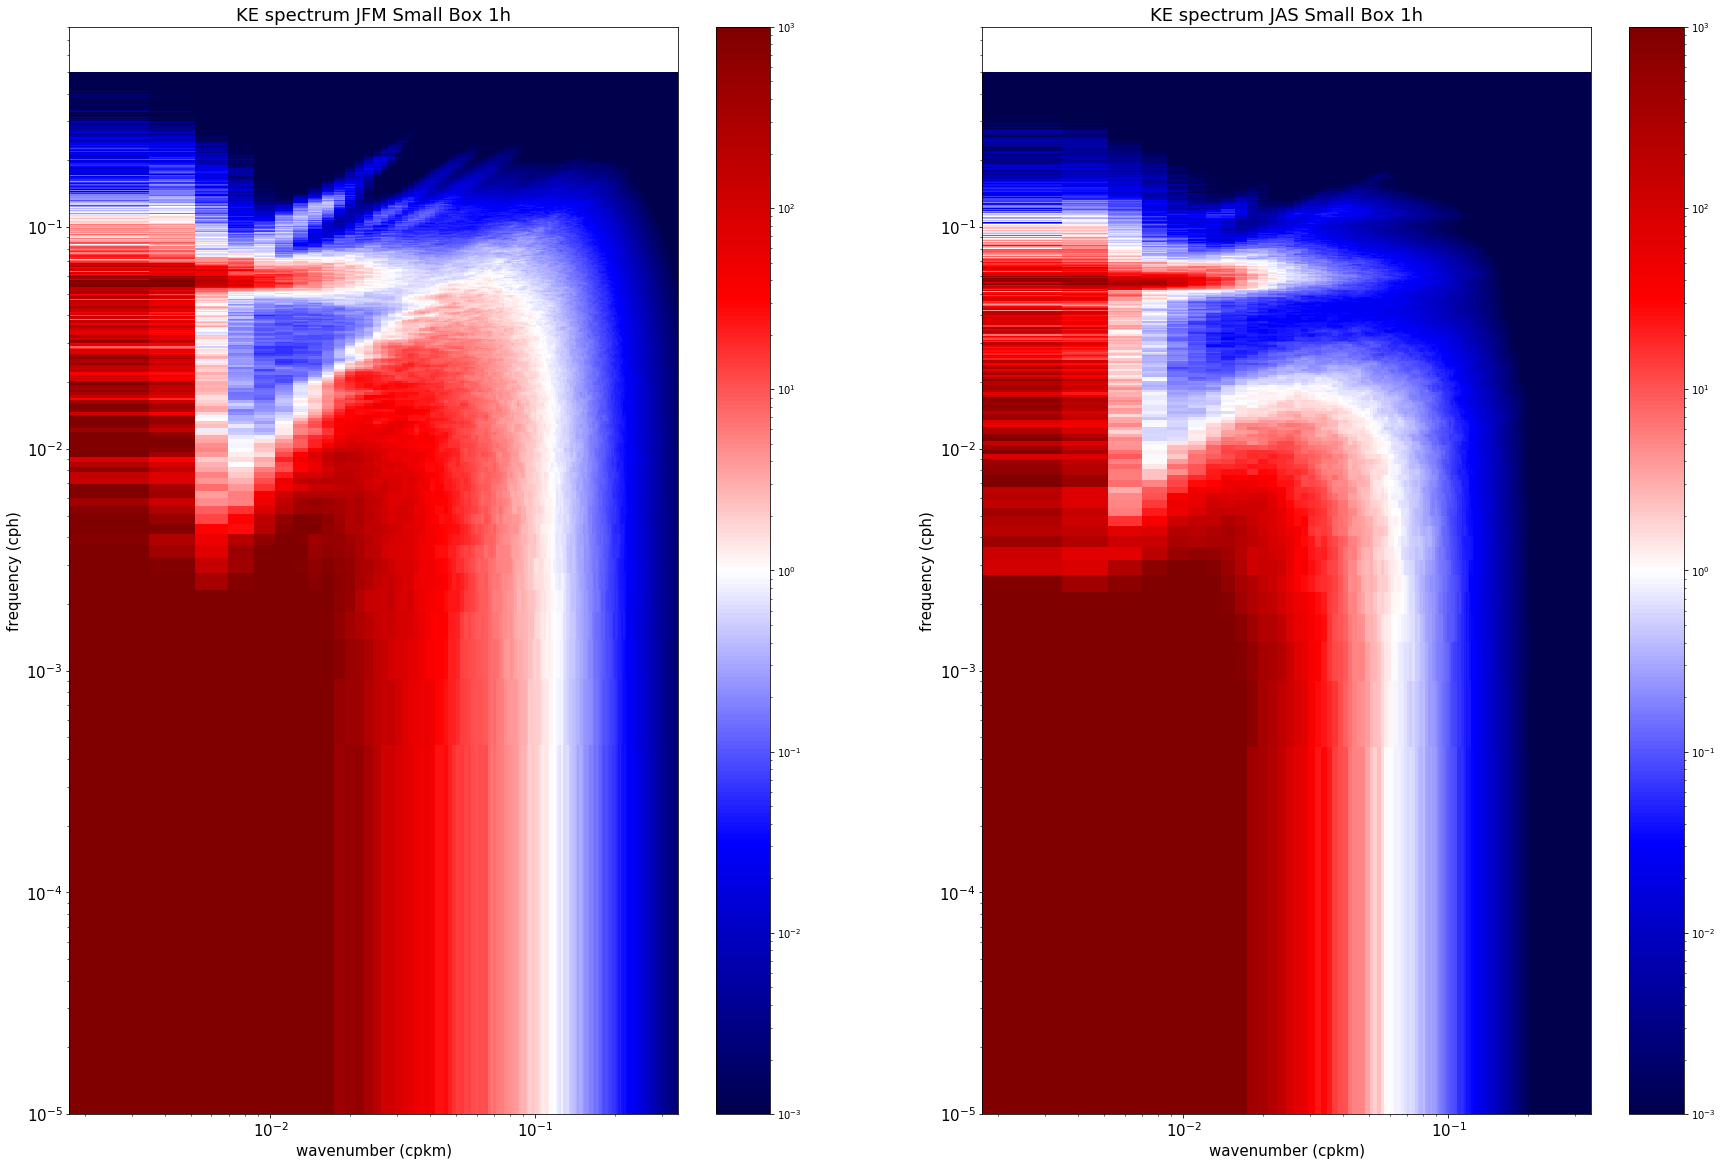

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


In [12]:
ds_JFM=xr.open_dataset('KE_Spectrum_JFM_w_k_from_1h_NATL60-CJM165.nc')
ds_JAS=xr.open_dataset('KE_Spectrum_JAS_w_k_from_1h_NATL60-CJM165.nc')

wavenumber_JFM=ds_JFM['wavenumber']
frequency_JFM=ds_JFM['frequency']
KE_JFM_wavenum_freq_spectrum=ds_JFM['Ke_spectrum']

wavenumber_JAS=ds_JAS['wavenumber']
frequency_JAS=ds_JAS['frequency']
KE_JAS_wavenum_freq_spectrum=ds_JAS['Ke_spectrum']


sec_to_hour = 3600.0
norm = LogNorm(vmin=0.001,vmax=1000)
cmap = div_cmap

fig=plt.figure(figsize=(30,20))

ax = plt.subplot(121)
plt.pcolormesh(wavenumber_JFM,sec_to_hour*frequency_JFM,KE_JFM_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JFM.min(),wavenumber_JFM.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JFM Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

ax = plt.subplot(122)
plt.pcolormesh(wavenumber_JAS,sec_to_hour*frequency_JAS,KE_JAS_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(wavenumber_JAS.min(),wavenumber_JAS.max())
ax.set_ylim(1E-5,8E-1)
ax.set_title('KE spectrum JAS Small Box 1h',size=18)
ax.tick_params(labelsize=15)
plt.legend
plt.colorbar()

#plt.title('run NATL60, year 2012, box : 40-45°Nx40-35°W')
plt.savefig('KE_spectrum_NATL60_JFM-JAS_smallbox.png')